## Random Forest Classifier for News dataset. 



In [392]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix

import math
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime
# Import 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold

In [393]:
import time
import os
import ast
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

import itertools
import re
import seaborn as sns

import nltk
from nltk.corpus import stopwords

In [394]:
from sklearn.metrics import confusion_matrix, f1_score

In [395]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [396]:
pd.options.display.max_columns
pd.set_option("display.max_columns",100)

### Import data

In [397]:
#data = pd.read_csv("../data/dataFACEBOOK.csv", thousands=',')
data = pd.read_csv("../../FINAL/data/dataFACEBOOK.csv", thousands=',')
#data['Total Interactions'] = data['Total Interactions'].replace(',','.', regex=True).astype(float)

In [398]:
data = data.rename(columns={'difficulty': 'Difficulty','title_polarity': 'Title polarity', 
                          'length':'Length', 'anger':'Anger' , 'positivity': 'Positivity',
       'joy':'Joy', 'disgust':'Disgust', 'surprise':'Surprise', 'trust':'Trust', 'anticipation':'Anticipation', 
                                'sadness':'Sadness',
      'fear':'Fear', 'numbers':'Numbers', 'polarity': 'Polarity', 'lexical richness': 'Lexical richness',
       'cosine': 'Cosine Similarity', 'sad':'Sad_', 'happy': 'Happy', 'inspired': 'Inspired', 
                                'dont_care':'I do not care', 'annoyed':'Annoyed', 'amused':'Amused',
       'afraid':'Afraid', 'sentence length':'Sentence length', 'mistakes':'Mistakes', 'adjectives':'Adjectives',
       'diversity':'Diversity', 'balance':'Balance',  'Strong_subjectivity':'Strong subjectivity',
       'Weak_subjectivity':'Weak subjectivity', 
       'Anger_intensity': 'Anger intensity', 'Joy_intensity':'Joy intensity', 
                                'Sadness_intensity':'Sadness intensity',
       'Fear_intensity':'Fear intensity', 'caps_body':'Capitals in article'})

In [399]:
data
data.shape

(73036, 93)

In [402]:
data = data[[ 'url', 'Noimages', 'Publication', 'Length', 'Difficulty', 'first_person','Capitals in article', 
             'Anger', 'Positivity', 'Joy', 'Disgust', 'Surprise', 'Trust', 'Anticipation', 'Sadness', 'negative', 
             'Fear', 'density', 'Sad_', 'Happy', 'Inspired', 'I do not care', 'Annoyed', 'Amused', 'Afraid', 
             'Polarity', 'No Celebs', 'Adjectives', 'No Animals', 'No Crime', 'No Sensual', 'Entertainment', 
             'Diversity', 'Total Interactions', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 
             'Angry', 'Care', 'Overperforming', 'Strong subjectivity', 'Valence', 'Arousal', 'Dominance', 
             'Anger intensity', 'Joy intensity', 'Sadness intensity', 'Fear intensity', '#title_words', 
             'cursing',  'Title cursing', 'Subjectivity Message', 
             'Subjectivity Title', 'Caps Title', 'Caps Message', '!', '"', '?', 'quality'] ].copy()

In [404]:
data.dtypes

url              object
Noimages         object
Publication      object
Length          float64
Difficulty      float64
                 ...   
Caps Message      int64
!                 int64
"                 int64
?                 int64
quality           int64
Length: 63, dtype: object

In [405]:
data.quality.value_counts()

1    36518
0    36518
Name: quality, dtype: int64

In [88]:
data.Noimages = data.Noimages.astype(float)

In [89]:
data["img/word"] = data['Noimages']/data['Length']

In [406]:
data.isnull().sum().sum()

0

In [407]:
data= data.dropna()
data.shape

(73036, 63)

In [408]:
# ONLY TABLOIDS 

In [409]:
#data = data[data['quality']==0]
#data

In [410]:
data['Comments'].describe([.80, .90, .91, .95])

count    73036.000000
mean       360.146435
std        707.851126
min          0.000000
50%        139.000000
80%        500.000000
90%        895.000000
91%        966.000000
95%       1400.000000
max      32410.000000
Name: Comments, dtype: float64

In [411]:
data['Comments'].describe([.10, .15, .05])

count    73036.000000
mean       360.146435
std        707.851126
min          0.000000
5%           3.000000
10%          8.000000
15%         16.000000
50%        139.000000
max      32410.000000
Name: Comments, dtype: float64

In [412]:
data['Comments'].describe()

count    73036.000000
mean       360.146435
std        707.851126
min          0.000000
25%         37.000000
50%        139.000000
75%        397.000000
max      32410.000000
Name: Comments, dtype: float64

In [413]:
data[data['Comments'] <1].shape

(1378, 63)

In [414]:
data[data['Comments'] >2273].shape

(1514, 63)

In [415]:
data_good = data[data['Comments'] >2273] #'Total Interactions']>15000  ['Shares'] >1986
data_good.shape

(1514, 63)

In [416]:
data_good['engagement'] = 1

In [418]:
data_bad = data[data['Comments'] <1] 
data_bad.shape


(1378, 63)

In [419]:
data_bad['engagement'] = 0

In [420]:
#data_bad2 = data_bad.sample(11442)

## Concat the data

In [421]:
pdList = [data_bad, data_good]  # List of your dataframes
data= pd.concat(pdList)

In [422]:
data.shape

(2892, 64)

In [423]:
data['Subjectivity Title'] = pd.to_numeric(data['Subjectivity Title'], errors='coerce')

In [424]:
data['Subjectivity Message'] = pd.to_numeric(data['Subjectivity Message'], errors='coerce')

In [425]:
data.reset_index(drop=True, inplace=True)

In [543]:
features= ['Length', 'No Celebs', 'Difficulty', 'Dominance', 'Anticipation', 'No Animals', 'Diversity', 
           '#title_words']

In [544]:
data[features].describe()

,Length,No Celebs,Difficulty,Dominance,Anticipation,No Animals,Diversity,#title_words
count,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000
mean,693.716951,0.753198,52.624733,0.554269,6.197043,1.523454,4.444030,15.330490
std,702.999520,1.491081,10.966952,0.038701,2.513439,5.046132,4.364042,6.806628
min,107.000000,0.000000,11.000000,0.442623,0.450450,0.000000,0.000000,4.000000
25%,340.000000,0.000000,45.000000,0.527041,4.470497,0.000000,2.000000,11.000000
50%,491.500000,0.000000,54.000000,0.553546,5.820050,0.000000,3.000000,13.000000
75%,817.250000,1.000000,60.000000,0.583314,7.638889,1.000000,6.000000,16.000000
max,13744.000000,14.000000,83.000000,0.692228,17.210682,160.000000,39.000000,45.000000


In [545]:
data[features].dtypes

Length          float64
No Celebs       float64
Difficulty      float64
Dominance       float64
Anticipation    float64
No Animals      float64
Diversity       float64
#title_words    float64
dtype: object

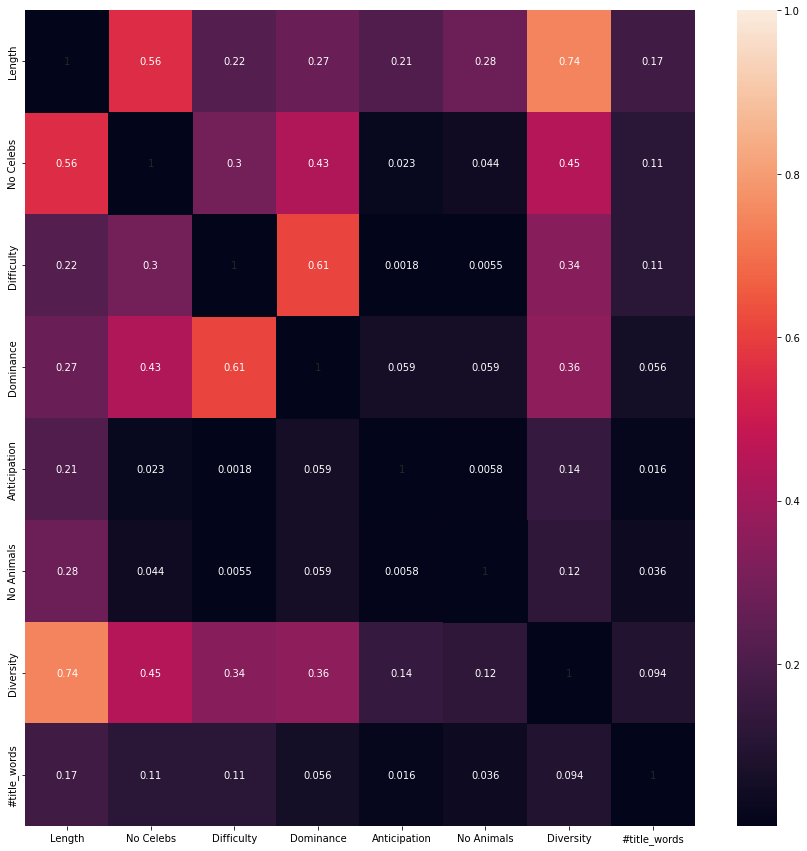

In [546]:
import math
import matplotlib.pyplot as plt
%matplotlib inline 

correlationMatrix = data[features].corr().abs()

plt.subplots(figsize=(15, 15))
sns.heatmap(correlationMatrix,annot=True)

# Mask unimportant features
sns.heatmap(correlationMatrix, mask=correlationMatrix < 1, cbar=False)
plt.show()

from scipy.cluster import hierarchy as hc
from scipy import linalg, optimize
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

corr = np.round(scipy.stats.spearmanr(data[features]).correlation, 5)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(20,15))
dendrogram = hc.dendrogram(z, labels=data[features].columns, orientation='left', leaf_font_size=19)
plt.show()

In [547]:
data.isnull().values.any()

False

In [548]:
data.isnull().sum().sum()

0

In [549]:
data.isnull().any()

url            False
Noimages       False
Publication    False
Length         False
Difficulty     False
               ...  
!              False
"              False
?              False
quality        False
engagement     False
Length: 64, dtype: bool

In [550]:
#nan_rows = data[data['Fear_intensity'].isnull()]
#nan_rows 

In [551]:
data = data.dropna()

# Model construction starts here

In [553]:
X = data[features]
y = data['engagement']

In [554]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=10)

In [555]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1500, 8), (376, 8), (1500,), (376,))

# Logistic Regression

In [556]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train,y_train)

Y_pred_lr = lr.predict(X_val)

In [557]:
score_lr = round(accuracy_score(Y_pred_lr,y_val)*100,2)

print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")

The accuracy score achieved using Logistic Regression is: 85.64 %


In [558]:
#f1_score(y_val, Y_pred_lr, average='weighted')

In [559]:
print('Classification Report\n', classification_report(y_val, Y_pred_lr))

Classification Report
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       164
           1       0.88      0.86      0.87       212

    accuracy                           0.86       376
   macro avg       0.85      0.86      0.85       376
weighted avg       0.86      0.86      0.86       376



In [560]:
# Import 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Ξεκινήστε τη λίστα βαθμολογίας μοντέλου
model_score = []
# Δημιουργήστε μια λίστα με τις πραγματικές τιμές
true_labels = []
# Δημιουργήστε τη λίστα των προβλεπόμενων τιμών
predicted_labels = []
# Ορίστε το αντικείμενο σταυροειδούς επαλήθευσης (cv)
our_cv = RepeatedKFold(n_splits=10, n_repeats=10)
# Ορίστε το Logistic Regression 
log_reg = LogisticRegression(penalty='none', random_state=123, solver='saga', max_iter = 10000, warm_start=True)
# Λούπα που παράχθηκε από τα κοψίματα του cv
for i_train, i_test in our_cv.split(X):
    # Ορίστε τα σετς
    X_train, X_val, y_train, y_val = X.iloc[i_train], X.iloc[i_test], y.iloc[i_train], y.iloc[i_test]
    # Fitting του logistic regression
    log_reg.fit(X_train, y_train.astype('int'))
#    importances = pd.DataFrame(data={
#    'Attribute': X_train.columns,
#    'Importance': model.coef_[0]
#    })
#    importances = importances.sort_values(by='Importance', ascending=False)
    # Πρόβλεψη των δεδομένων του testing σετ
    y_pred_test = log_reg.predict(X_val)
    # Λήψη βαθμολογίας ακρίβειας
    model_score.append(accuracy_score(y_val.astype('int'), y_pred_test.astype('int')))
    # Προσθέστε τις αληθινές τιμές στη λίστα
    true_labels.extend(y_val.astype('int'))
    # Προσθέστε τις προβλεπόμενες τιμές στη λίστα
    predicted_labels.extend(y_pred_test.astype('int'))

In [561]:
#Υπολογίστε τη μέση ακρίβεια κατά την 10 x 10 σταυροειδή επαλήθευση
# Χρήση του μέσου όρου για 100 τιμές μέσα στο model_score
print("Η μέση ακρίβεια του μοντέλου λογιστικής παλινδρόμησης είναι: "+str(np.mean(model_score))+" %")

Η μέση ακρίβεια του μοντέλου λογιστικής παλινδρόμησης είναι: 0.8405196836955285 %


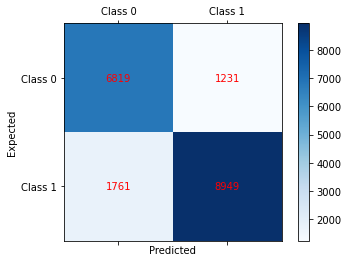

In [562]:
from sklearn.metrics import confusion_matrix
# Υπολογισμός 
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
# Ορισμός των labels 
labels = ['Class 0', 'Class 1']
# Ξεκινήστε ένα άδειο σχήμα
fig = plt.figure()
# Προσθέστε άξονα στο σχήμα
ax = fig.add_subplot(111)
# Προσθέστε τον πίνακα
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
# Εμφάνιση γραμμής χρωμάτων
fig.colorbar(cax)
# Αφαίρεση των x και y ticks
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
# Προσθέστε τα labels x και y
plt.xlabel('Predicted')
plt.ylabel('Expected')
# Προσθέστε νέα x και y ticks
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='r')
# Τυπώστε τον πίνακα
plt.show()

In [563]:
model = LogisticRegression()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

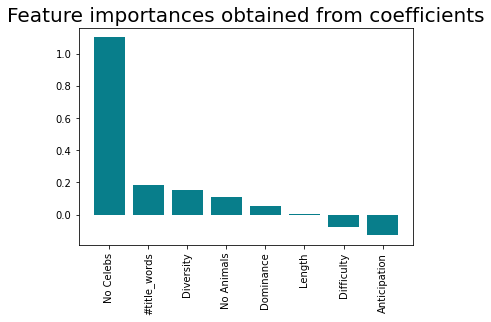

In [564]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

# SVM

In [565]:
from sklearn import svm

sv = svm.SVC(kernel='linear')

sv.fit(X_train, y_train)

Y_pred_svm = sv.predict(X_val)

In [566]:
f1_score(y_val, Y_pred_svm, average='weighted')

0.9142610102362423

# Study the Decision Tree Classifier

In [567]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import RepeatedKFold

In [568]:
from sklearn.tree import DecisionTreeClassifier

max_accuracy = 0

for x in range(2000):
    dt = DecisionTreeClassifier(random_state=x, max_depth = 8)
    dt.fit(X_train,y_train)
    Y_pred_dt = dt.predict(X_val)
    current_accuracy = round(accuracy_score(Y_pred_dt,y_val)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)

dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,y_train)
Y_pred_dt = dt.predict(X_val)

In [569]:
f1_score(y_val, Y_pred_dt, average='weighted')

0.8384498501625

In [570]:
print('Classification Report\n', classification_report(y_val, Y_pred_dt))

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.77      0.80        77
           1       0.84      0.89      0.87       110

    accuracy                           0.84       187
   macro avg       0.84      0.83      0.83       187
weighted avg       0.84      0.84      0.84       187



In [571]:
#saving the tree https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn
from graphviz import Source
from sklearn import tree
#Source( tree.export_graphviz(estimator, out_file=None, feature_names=X.columns))

# Study now the Random Forest Classifier

In [572]:
rf = RandomForestClassifier()

In [573]:
#Get the best RF Classifier from the grid

In [574]:
rf = RandomForestClassifier()
grid = {'min_samples_leaf' : [15, 20], 'max_features' : ['auto'], 
        'min_samples_split' : [   40, 60]
       }
clf = GridSearchCV(rf, grid, cv=5)
clf.fit(X_train, y_train)
#best_clf = clf.best_estimator_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto'], 'min_samples_leaf': [15, 20],
                         'min_samples_split': [40, 60]})

In [575]:
clf_val_pred_probs = clf.predict_proba(X_val)

clf_val_pred = clf.predict(X_val)

In [540]:
# Get the f1 Score of the best RF classifier of the grid

f1_score(y_val, clf_val_pred, average='macro')

0.8554661781123865

In [541]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [542]:
print(classification_report(y_val, clf_val_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85        86
           1       0.90      0.82      0.86       101

    accuracy                           0.86       187
   macro avg       0.86      0.86      0.86       187
weighted avg       0.86      0.86      0.86       187



# Lets Try a RF classifier selecting manually the parameters

In [463]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf.fit(X_train, y_train)

val_pred_probs = rf.predict_proba(X_val)

val_pred = rf.predict(X_val)

In [464]:
train_pred_probs = rf.predict_proba(X_train)
train_pred = rf.predict(X_train)


In [465]:
log_loss(y_val, val_pred_probs, labels=rf.classes_)

0.3385646084482843

In [466]:
log_loss(y_train, train_pred_probs, labels=rf.classes_)

0.29642814011920615

In [467]:
f1_score(y_val, clf_val_pred, average='macro')

0.8870675524113537

In [468]:
fi = pd.DataFrame(rf.feature_importances_, X_train.columns)
fi.columns = ['Importance']
fi.sort_values(by = 'Importance', ascending=False)[0:20]

,Importance
Length,0.223960
#title_words,0.220014
No Celebs,0.148701
Diversity,0.127932
Dominance,0.118671
Difficulty,0.092670
Anticipation,0.045753
No Animals,0.022300


f1_score(y_val, val_pred, average='macro')

In [469]:
fi = pd.DataFrame(rf.feature_importances_, X_train.columns)
fi.columns = ['Importance']
fi.sort_values(by = 'Importance', ascending=False)[0:20]

,Importance
Length,0.223960
#title_words,0.220014
No Celebs,0.148701
Diversity,0.127932
Dominance,0.118671
Difficulty,0.092670
Anticipation,0.045753
No Animals,0.022300


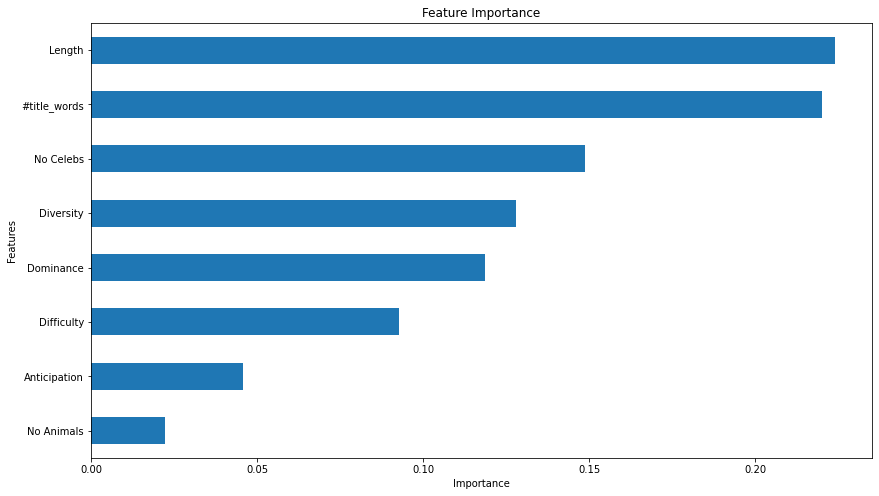

In [470]:
import matplotlib.pyplot as plt

plot = fi.sort_values(by = 'Importance', ascending=True).tail(15).plot.barh(figsize = (14,8), legend = False, title = 'Feature Importance', 
                                                                           )

#plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

fig = plot.get_figure()
#fig.savefig('Importance_News_75.png')



In [471]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Automatically created module for IPython interactive environment


Confusion matrix, without normalization
[[76 11]
 [10 90]]


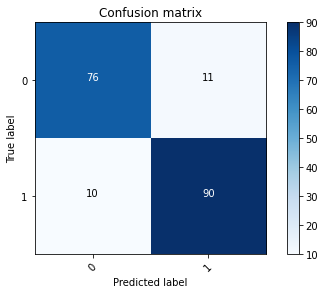

In [472]:
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_train, train_pred)

cnf_matrix = confusion_matrix(y_val, val_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rf.classes_,
                      title='Confusion matrix')


In [473]:
# Check AGAIN the accurance of the manually defined RF classifier

f1_score(y_val, val_pred, average='macro')

0.8870675524113537

In [474]:
print(classification_report(y_val, clf_val_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88        87
           1       0.89      0.90      0.90       100

    accuracy                           0.89       187
   macro avg       0.89      0.89      0.89       187
weighted avg       0.89      0.89      0.89       187



In [475]:
n_nodes = []
max_depths = []

for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Total number of Trees {int(len(rf.estimators_))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


Total number of Trees 2000
Average number of nodes 68
Average maximum depth 11


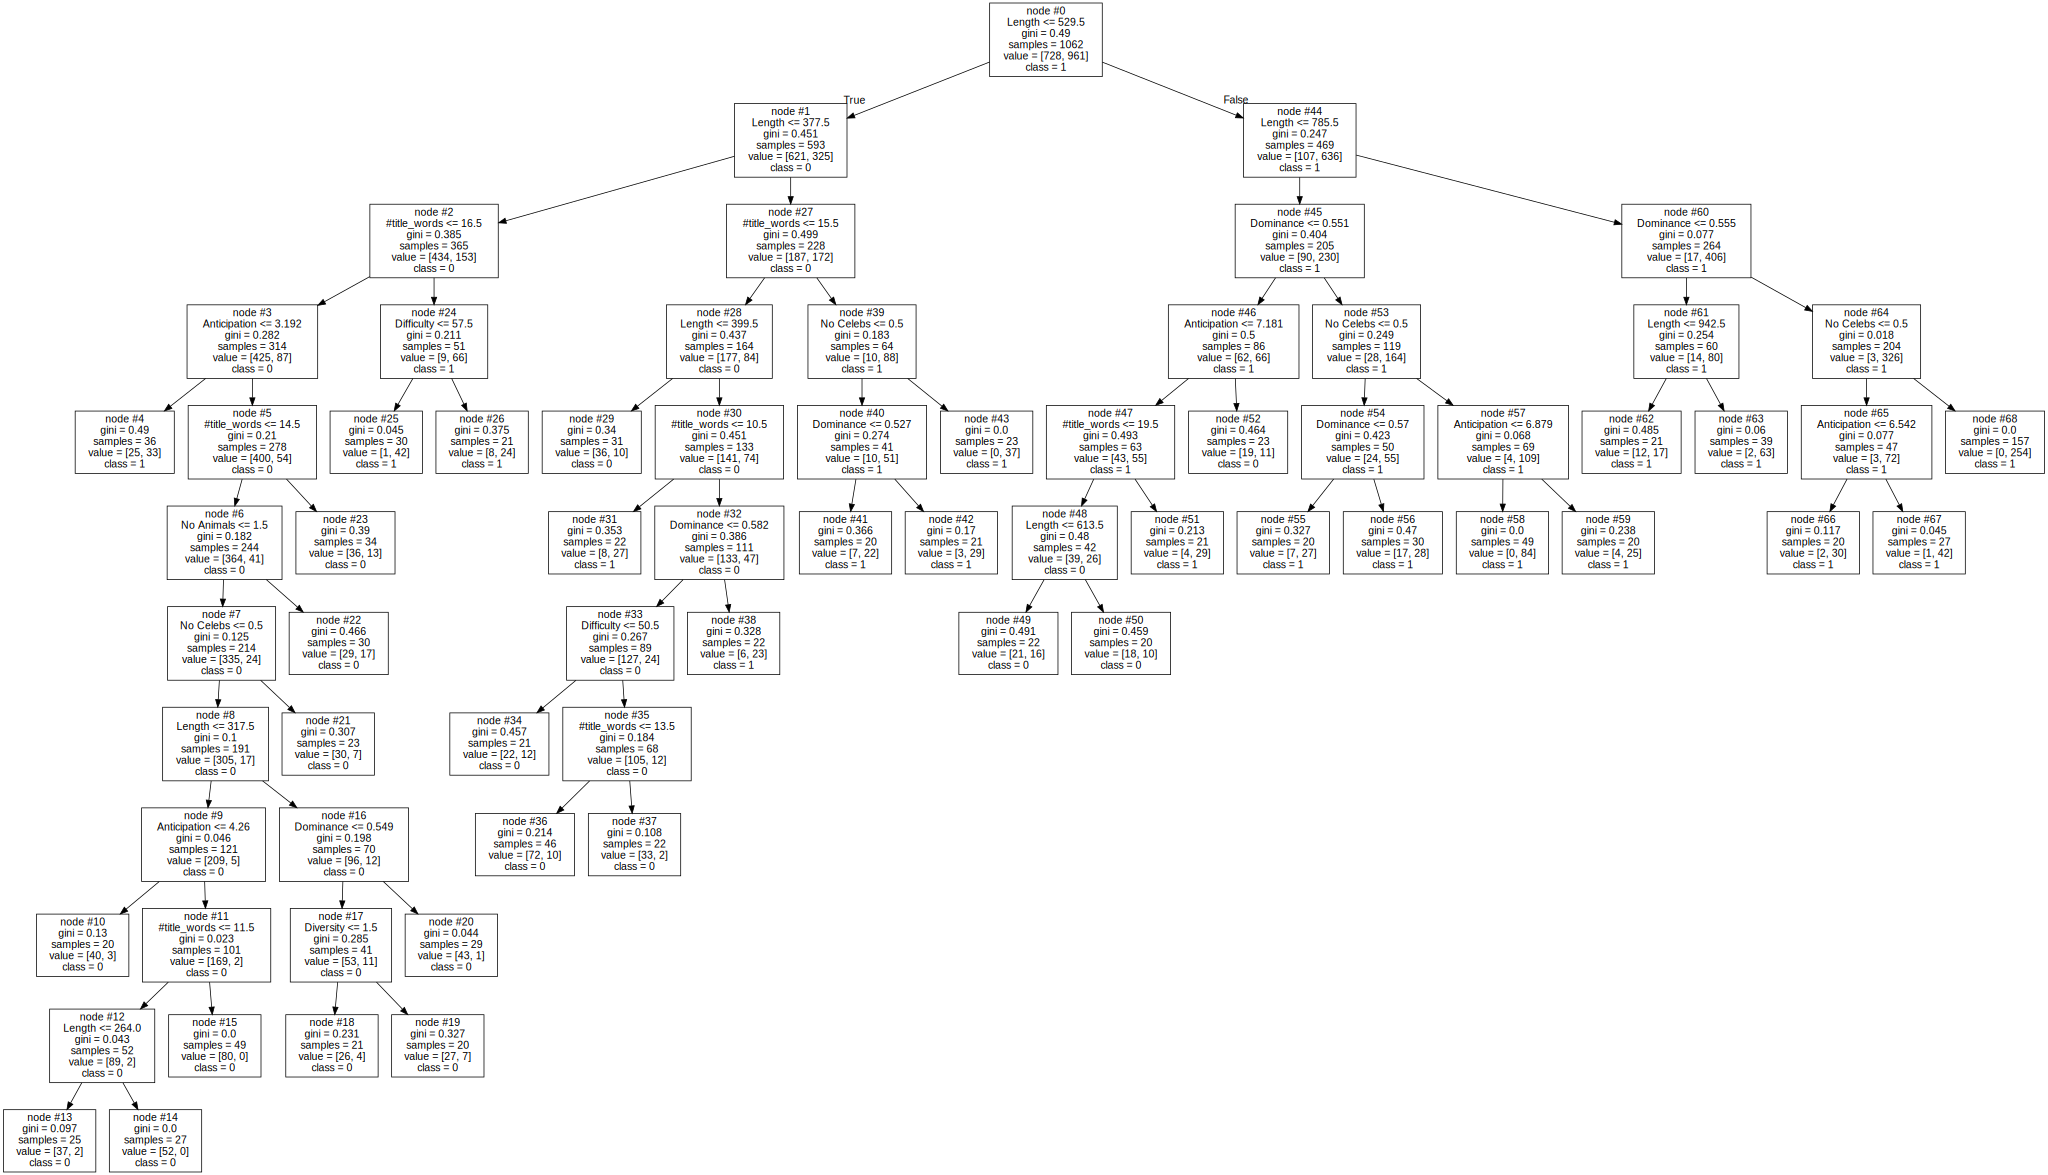

In [476]:
# visualizing the nth tree of the Random Forest (n=0)
import graphviz
from sklearn.tree import export_graphviz

#dot_data = export_graphviz(rf.estimators_[0])
graphviz.Source(export_graphviz(rf.estimators_[10],
                                out_file=None,
                                feature_names=features,
                                class_names=["0", "1"],
                                node_ids = True,
                                impurity=True))

In [477]:
MAX_ROUNDS = 180
OPTIMIZE_ROUNDS = True
LEARNING_RATE = 0.1
EARLY_STOPPING_ROUNDS = 55  
# Note: I set EARLY_STOPPING_ROUNDS high so that (when OPTIMIZE_ROUNDS is set)
#       I will get lots of information to make my own judgment.  You should probably
#       reduce EARLY_STOPPING_ROUNDS if you want to do actual early stopping.

In [478]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
#from numba import jit
import time
import gc

In [479]:
# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
#@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]



In [480]:
# Set up classifier
model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=8,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

In [481]:
fit_model_xgb = model.fit(X_train,y_train)

In [482]:
val_pred_xgb = fit_model_xgb.predict(X_val)

Confusion matrix, without normalization
[[74 13]
 [ 7 93]]


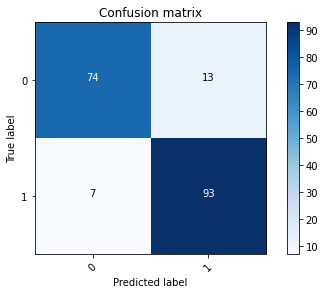

In [483]:
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_train, train_pred)

cnf_matrix = confusion_matrix(y_val, val_pred_xgb)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rf.classes_,
                      title='Confusion matrix')


In [484]:
f1_score(y_val, val_pred_xgb, average='macro')

0.8919325011558021

In [485]:
print(classification_report(y_val, clf_val_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88        87
           1       0.89      0.90      0.90       100

    accuracy                           0.89       187
   macro avg       0.89      0.89      0.89       187
weighted avg       0.89      0.89      0.89       187



In [486]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_val, clf_val_pred))


Accuracy :  0.8877005347593583


In [499]:
import xgboost as xgb

In [506]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_val, y_val)])

Y_pred_xgb = xgb_model.predict(X_val)

[0]	validation_0-auc:0.93057
[1]	validation_0-auc:0.92609
[2]	validation_0-auc:0.93224
[3]	validation_0-auc:0.93494
[4]	validation_0-auc:0.93293
[5]	validation_0-auc:0.93362
[6]	validation_0-auc:0.93172
[7]	validation_0-auc:0.93172


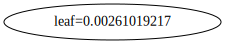

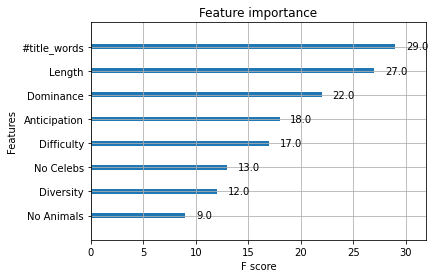

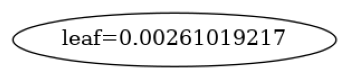

In [507]:
import graphviz
xgb.plot_importance(model)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
xgb.plot_tree(model, num_trees=model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(model, num_trees=model.best_iteration)

In [508]:
score_xgb = round(accuracy_score(Y_pred_xgb,y_val)*100,2)

print("The accuracy score achieved using XGBoost is: "+str(score_xgb)+" %")

The accuracy score achieved using XGBoost is: 89.84 %


In [487]:
import eli5

In [488]:
eli5.show_prediction(rf, X_val[features].iloc[0], show_feature_values=True)

In [489]:
eli5.show_prediction(rf, X_val[features].iloc[1], show_feature_values=True)

In [490]:
eli5.explain_prediction(rf, data[features].iloc[1])

Explanation(estimator='RandomForestClassifier(min_samples_leaf=20, min_samples_split=40,\n                       n_estimators=2000, n_jobs=1)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.5751142687981038, std=None, value=1.0), FeatureWeight(feature='Length', weight=0.20594301501436327, std=None, value=930.0), FeatureWeight(feature='Diversity', weight=0.16638758413598356, std=None, value=7.0), FeatureWeight(feature='No Animals', weight=0.016050903836972212, std=None, value=1.0), FeatureWeight(feature='Dominance', weight=0.010018290304671638, std=None, value=0.5646462585034021), FeatureWeight(feature='Anticipation', weight=0.0007549423437784777, std=None, value=5.251141552511415)], neg=[FeatureWeight(feature='Difficulty', weight=-0.08605598154266891, std=None, value=60.0), FeatureWeight(feature='No Celebs', weight=-0.08329258731766048, std=None, value=0.0), FeatureWeight(feature='#title_words', weight=-0.04939042602550049, std=None, value=11.0)], pos_remaining=0, neg_remaining=0), proba=0.7555300095480451, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [491]:
eli5.explain_weights(rf)

Weight,Feature
0.2240 ± 0.3408,x0
0.2200 ± 0.1600,x7
0.1487 ± 0.2970,x1
0.1279 ± 0.2700,x6
0.1187 ± 0.2266,x3
0.0927 ± 0.1797,x2
0.0458 ± 0.0611,x4
0.0223 ± 0.0516,x5


In [492]:
eli5.show_weights(fit_model_xgb, top = 10,feature_names = features)

Weight,Feature
0.2355,No Celebs
0.2147,Length
0.1797,#title_words
0.0981,Diversity
0.0858,Dominance
0.0842,Difficulty
0.0584,Anticipation
0.0436,No Animals


In [493]:
eli5.show_weights(rf, top = 10,feature_names = features)

Weight,Feature
0.2240 ± 0.3408,Length
0.2200 ± 0.1600,#title_words
0.1487 ± 0.2970,No Celebs
0.1279 ± 0.2700,Diversity
0.1187 ± 0.2266,Dominance
0.0927 ± 0.1797,Difficulty
0.0458 ± 0.0611,Anticipation
0.0223 ± 0.0516,No Animals


In [494]:
#https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rf).fit(X_train,y_train)
eli5.show_weights(perm, top = 10,  feature_names = X_train.columns.tolist() )

Weight,Feature
0.1099 ± 0.0235,#title_words
0.0692 ± 0.0072,Length
0.0247 ± 0.0077,No Celebs
0.0167 ± 0.0059,Diversity
0.0157 ± 0.0036,Dominance
0.0141 ± 0.0048,Difficulty
0.0076 ± 0.0032,Anticipation
0.0036 ± 0.0018,No Animals


In [369]:
fit_model_xgb.fit(X_train, y_train)
PI = PermutationImportance(fit_model_xgb, scoring='f1_weighted').fit(X_val, y_val)
eli5.show_weights(PI, feature_names = X_train.columns.tolist())

Weight,Feature
0.1649 ± 0.0228,#title_words
0.0566 ± 0.0321,Length
0.0411 ± 0.0265,No Celebs
0.0256 ± 0.0230,Difficulty
0.0179 ± 0.0149,Anticipation
0.0051 ± 0.0149,No Animals
0.0051 ± 0.0286,Diversity
-0.0038 ± 0.0063,Dominance


http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
prediction, bias, contributions = ti.predict(rf, X_val[features])


In [ ]:
prediction

In [ ]:
prediction1, bias1, contributions1 = ti.predict(rf, X_val[features])


In [ ]:
L = []

for pred, bias, contr in zip(prediction1, bias1, contributions1):
    d = {"pred0" : round(pred[0],2)}
    for c, feature in zip(contr,features):
       d.update({feature:round(c[0],2)})
#      print(feature, round(c[0],2))
    L.append(d)
ContributionsClass_df = pd.DataFrame(L)   


In [ ]:
plot = ContributionsClass_df[ContributionsClass_df['pred0']>0.5][features].mean().reindex(ContributionsClass_df[ContributionsClass_df['pred0']>0.5][features].mean().
           abs().sort_values(ascending=True).index).plot(kind='barh', figsize=(10,10))
fig = plot.get_figure()
#fig.savefig('Importance_News_tree for Class 0_75.png')

In [ ]:
import matplotlib.pyplot as plt


plot = ContributionsClass_df[ContributionsClass_df['pred0']>0.5][features].mean().reindex(ContributionsClass_df[ContributionsClass_df['pred0']>0.5][features].mean().
           abs().sort_values(ascending=True).index).tail(10).plot(kind='barh', figsize=(5,4),color= 'grey')

plt.xlabel('Importance')
plt.ylabel('Features')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
fig = plot.get_figure()
fig.savefig('Baseline.png', dpi=1000, bbox_inches='tight')
#fig.savefig('Importance_News_tree for Class 75.png')

In [ ]:
L = []

for pred, bias, contr in zip(prediction1, bias1, contributions1):
    d = {"pred1" : round(pred[1],2)}
    for c, feature in zip(contr,features):
       d.update({feature:round(c[1],2)})
#      print(feature, round(c[0],2))
    L.append(d)
ContributionsClassOne_df = pd.DataFrame(L)   


ContributionsClassOne_df[ContributionsClassOne_df['pred1']>0.5][features].mean().reindex(ContributionsClassOne_df[ContributionsClassOne_df['pred1']>0.5][features].mean().abs().sort_values(ascending=False).index)

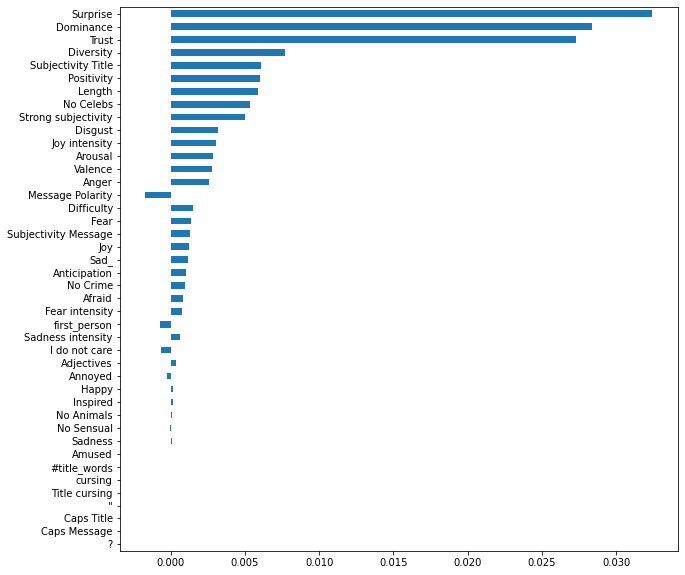

In [328]:
plot = ContributionsClassOne_df[ContributionsClassOne_df['pred1']>0.5][features].mean().reindex(ContributionsClassOne_df[ContributionsClassOne_df['pred1']>0.5][features].mean().
           abs().sort_values(ascending=True).index).plot(kind='barh', figsize=(10,10))
fig = plot.get_figure()
#fig.savefig('Importance_News_tree for Class 1_75.png')

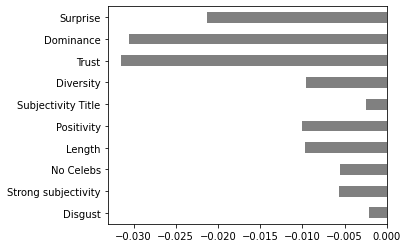

In [329]:
plot = ContributionsClassOne_df[ContributionsClassOne_df['pred1']<0.5][features].mean().reindex(ContributionsClassOne_df[ContributionsClassOne_df['pred1']>0.5][features].mean().
           abs().sort_values(ascending=True).index).tail(10).plot(kind='barh', figsize=(5,4),color= 'grey')
fig = plot.get_figure()
fig.savefig('Importance_News_tree_small for Class 1_75.png')


